In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

plots_dir = '/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/plots/by_game'
games_names = ["prisoners_dilemma", "stag_hunt", "generic", "hawk_dove", "chicken", "coordination"]

In [4]:
def count_strategy_switches(actions):
    if not actions or len(actions) < 2:
        return 0
    return sum(1 for i in range(1, len(actions)) if actions[i] != actions[i-1])


In [5]:
full_path = "/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/combo.csv"
df = pd.read_csv(full_path, converters={
        'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
        'total_rounds': int
    })

df = df[df['game_name'].isin(games_names)]

nonmbti = ['NONE', 'ALTRUISTIC', 'SELFISH']
# Map each personality to its dichotomies
df['I/E_1'] = df['personality_1'].apply(lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None)
df['N/S_1'] = df['personality_1'].apply(lambda x: 'N' if x[1] == 'N' else 'S' if x not in nonmbti else None)
df['T/F_1'] = df['personality_1'].apply(lambda x: 'T' if x[2] == 'T' else 'F' if x not in nonmbti else None)
df['J/P_1'] = df['personality_1'].apply(lambda x: 'J' if x[3] == 'J' else 'P' if x not in nonmbti else None)

df['I/E_2'] = df['personality_2'].apply(lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None)
df['N/S_2'] = df['personality_2'].apply(lambda x: 'N' if x[1] == 'N' else 'S' if x not in nonmbti else None)
df['T/F_2'] = df['personality_2'].apply(lambda x: 'T' if x[2] == 'T' else 'F' if x not in nonmbti else None)
df['J/P_2'] = df['personality_2'].apply(lambda x: 'J' if x[3] == 'J' else 'P' if x not in nonmbti else None)

df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

#parse as lists, something went wrong when saving the csv
df['truthful_agent_1'] = df['truthful_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['truthful_agent_2'] = df['truthful_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Parse the actions as lists of strings
df['agent_1_actions'] = df['agent_1_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_actions'] = df['agent_2_actions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_1_messages'] = df['agent_1_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['agent_2_messages'] = df['agent_2_messages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_1'] = df['intent_agent_1'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['intent_agent_2'] = df['intent_agent_2'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['strategy_switches_agent_1'] = df['agent_1_actions'].apply(count_strategy_switches)
df['strategy_switches_agent_2'] = df['agent_2_actions'].apply(count_strategy_switches)

# Calculate the average cost per round for each row
df['cost_per_round'] = df['total_cost_USD'] / df['total_rounds']

## plot the final scores of each agent of each game

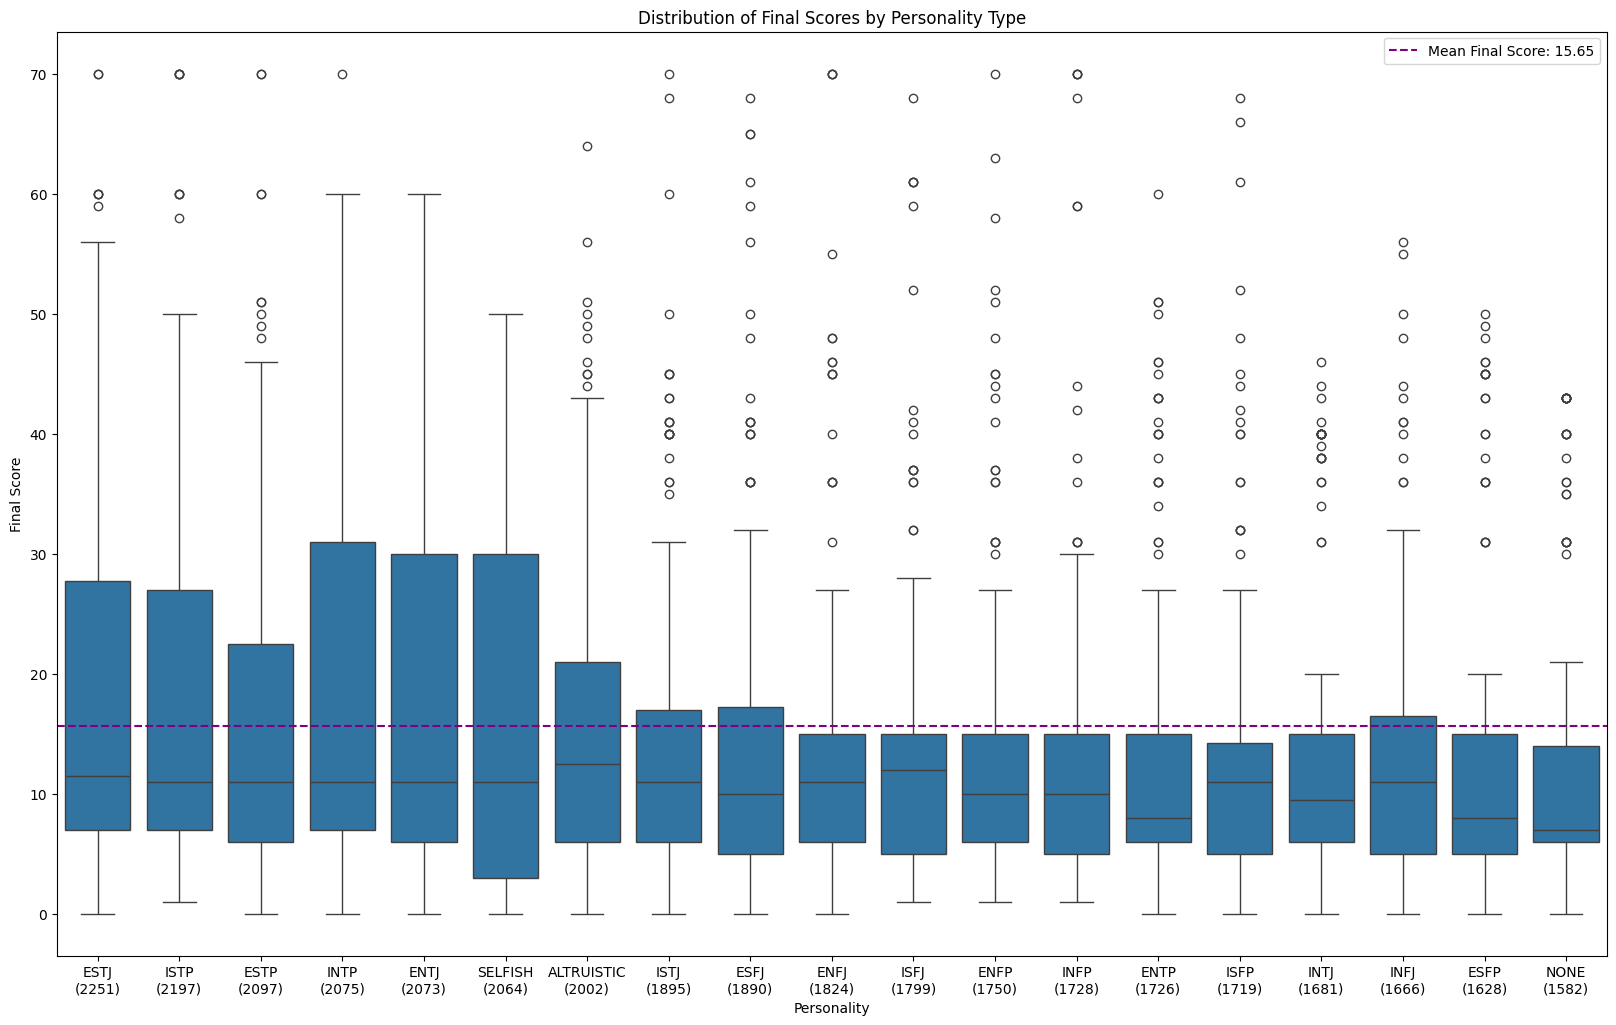

/tmp/ipykernel_3830161/883404308.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')


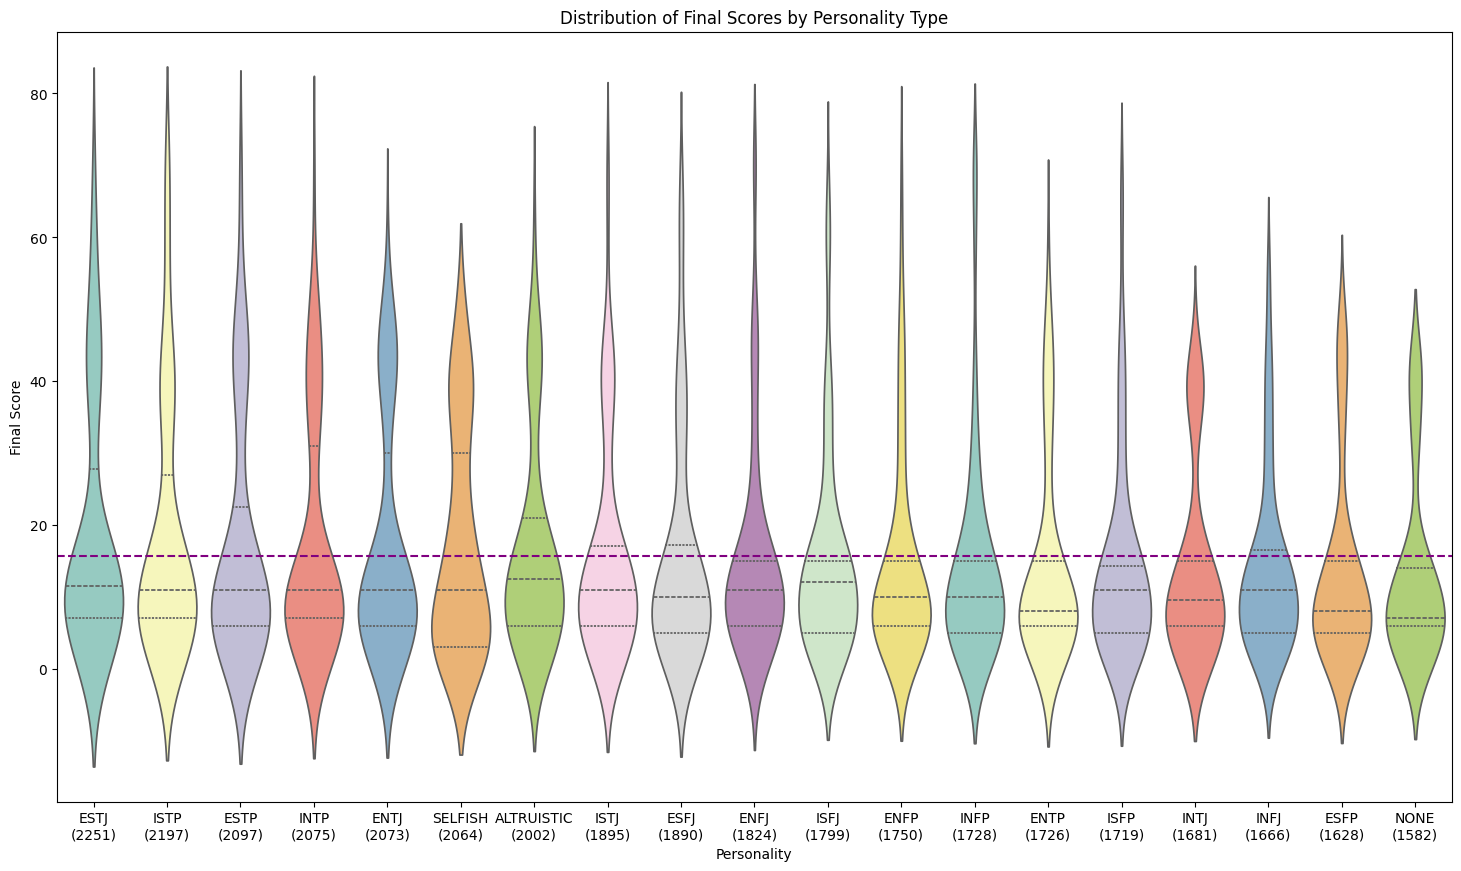

In [6]:
# Extract the final scores and personality types
final_scores = []
for i, row in df.iterrows():
    final_scores.append({'Personality': row['personality_1'], 'Final Score': row['agent_1_cumulative_scores'][-1]})
    final_scores.append({'Personality': row['personality_2'], 'Final Score': row['agent_2_cumulative_scores'][-1]})

# Create a DataFrame from the final scores
final_scores_df = pd.DataFrame(final_scores)
mean_final_score = final_scores_df['Final Score'].mean()

# Calculate total scores across all games for each personality
total_scores = final_scores_df.groupby('Personality')['Final Score'].sum().reset_index()
total_scores = total_scores.sort_values(by='Final Score', ascending=False)
total_scores_dict = total_scores.set_index('Personality')['Final Score'].to_dict()

# Sort final_scores_df by the total scores
final_scores_df['Total Score'] = final_scores_df['Personality'].map(total_scores_dict)
final_scores_df = final_scores_df.sort_values(by='Total Score', ascending=False).drop(columns=['Total Score'])

# Plot the distribution of final scores by personality type using box plot
plt.figure(figsize=(20, 12))
sns.boxplot(data=final_scores_df, x='Personality', y='Final Score')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend()
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.xlabel('Personality')
plt.ylabel('Final Score')
#save_plot using the name of the games and the run_ids
#plt.savefig(f"final_scores_boxplot_{
plt.show()

# Plot the distribution of final scores by personality type using violin plot
plt.figure(figsize=(18, 10))
sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

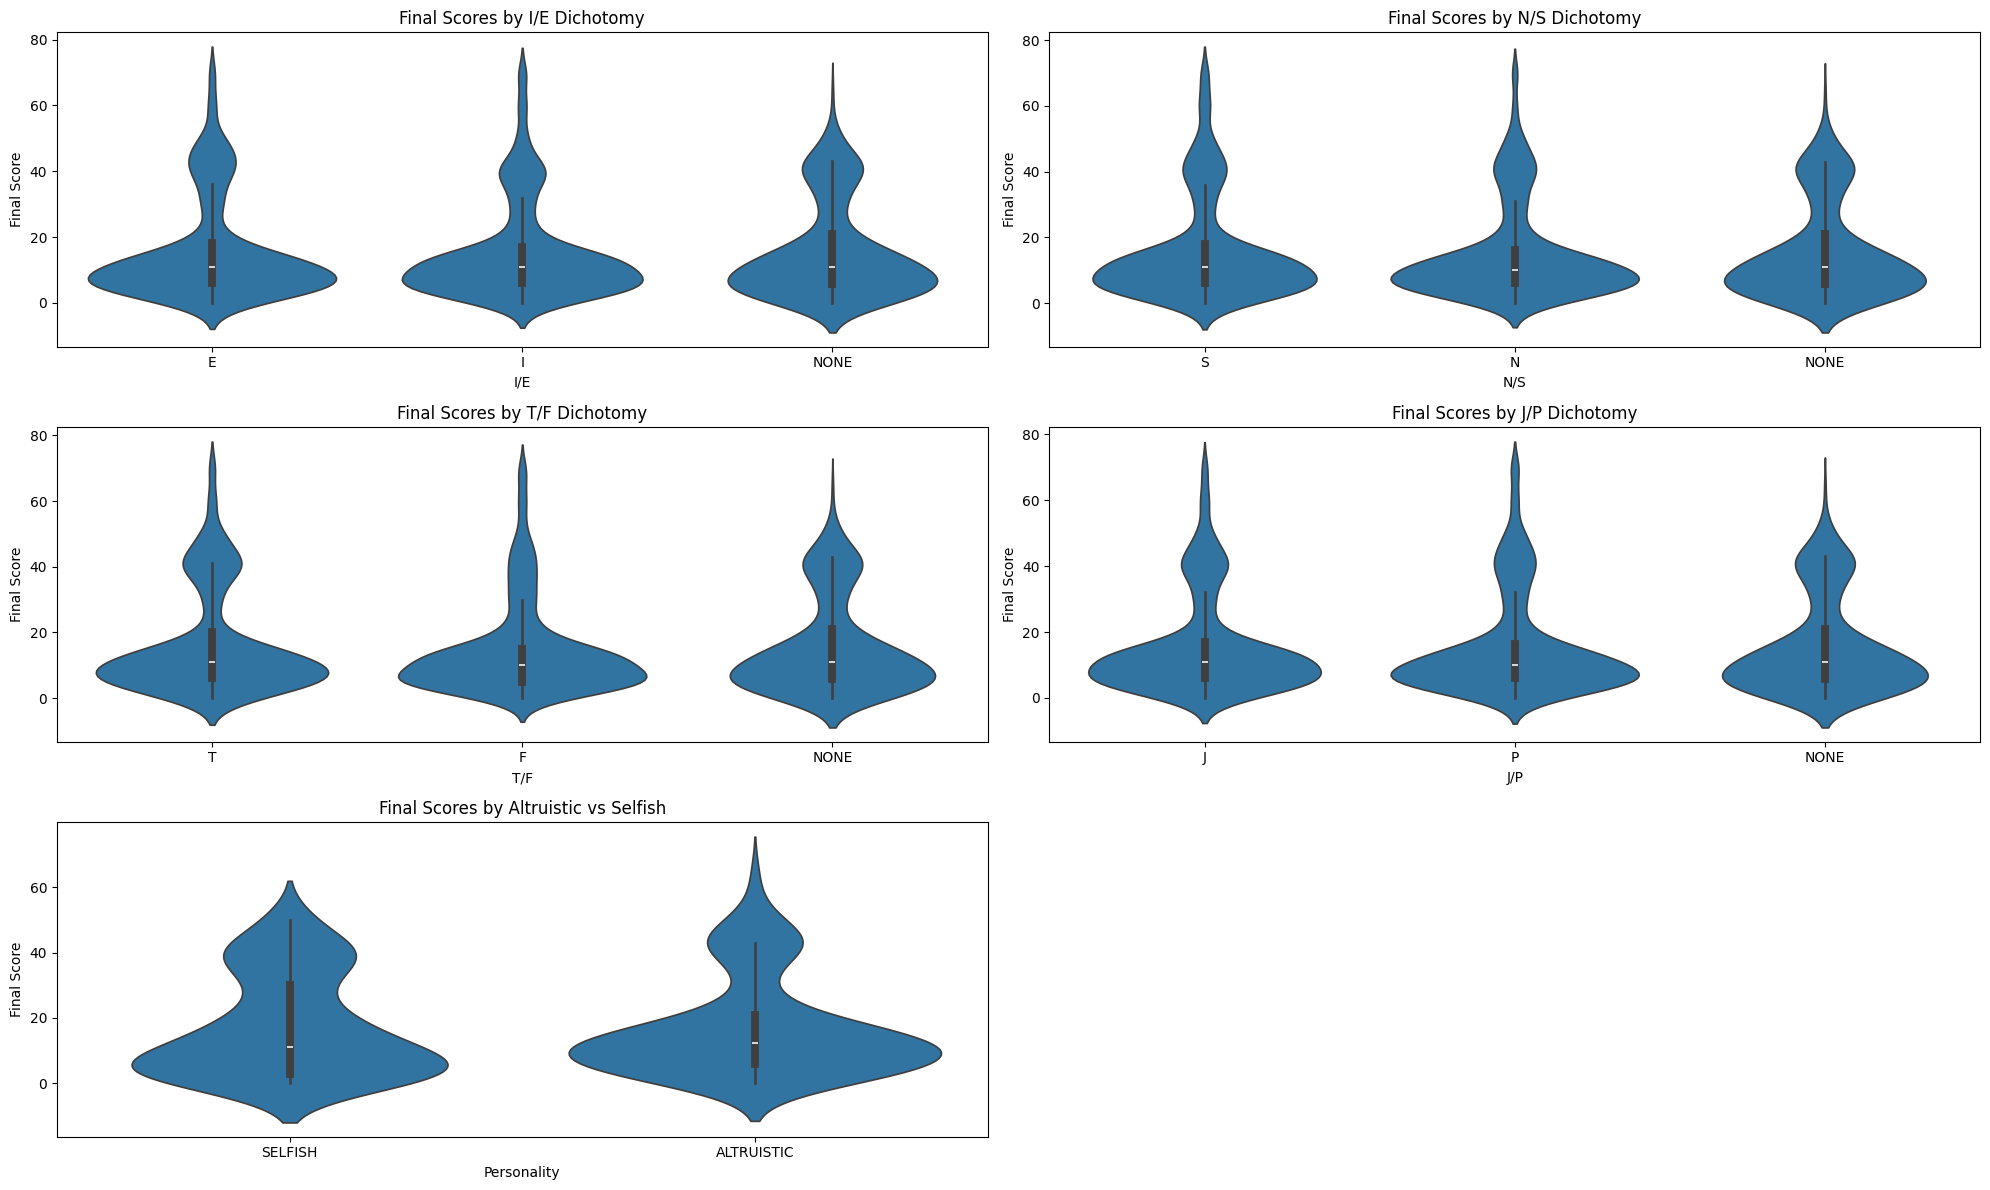

In [7]:
# Filter out the control groups
filtered_df = final_scores_df[~final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Final Score'] = filtered_df['Final Score']

# Add NONE, ALTRUISTIC, and SELFISH to the dichotomies DataFrame
control_df = final_scores_df[final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
control_df['I/E'] = 'NONE'
control_df['N/S'] = 'NONE'
control_df['T/F'] = 'NONE'
control_df['J/P'] = 'NONE'
dichotomies_df = pd.concat([dichotomies_df, control_df])

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Final Score')
plt.title('Final Scores by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Final Score')
plt.title('Final Scores by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Final Score')
plt.title('Final Scores by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Final Score')
plt.title('Final Scores by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=final_scores_df[final_scores_df['Personality'].isin(['ALTRUISTIC', 'SELFISH'])], x='Personality', y='Final Score')
plt.title('Final Scores by Altruistic vs Selfish')

plt.tight_layout()
plt.show()

## plot mean cummulative scores
some scores that start of strong, end up worse than others: guessing because agents don t tolerate repeated lying and then just defect each round as well.
Maybe with a alonger game, the difference would be even more clear.

Personality: NONE, Mean Cumulative Scores: [0.0, 2.683333333333333, 4.933333333333334, 6.633333333333334, 8.25, 9.916666666666666, 11.558333333333334, 13.183333333333334]
Personality: ISTJ, Mean Cumulative Scores: [0.0, 3.05, 5.691666666666666, 7.758333333333334, 9.833333333333334, 11.775, 13.758333333333333, 15.791666666666666]
Personality: ISFJ, Mean Cumulative Scores: [0.0, 2.5833333333333335, 4.966666666666667, 7.008333333333334, 9.266666666666667, 11.083333333333334, 12.983333333333333, 14.991666666666667]
Personality: INFJ, Mean Cumulative Scores: [0.0, 2.26890756302521, 4.705882352941177, 6.378151260504202, 8.453781512605042, 10.285714285714286, 12.126050420168067, 14.0]
Personality: INTJ, Mean Cumulative Scores: [0.0, 3.075, 5.133333333333334, 6.966666666666667, 8.583333333333334, 10.258333333333333, 12.2, 14.008333333333333]
Personality: ISTP, Mean Cumulative Scores: [0.0, 3.630252100840336, 6.4789915966386555, 8.831932773109244, 11.184873949579831, 13.672268907563025, 16.2521

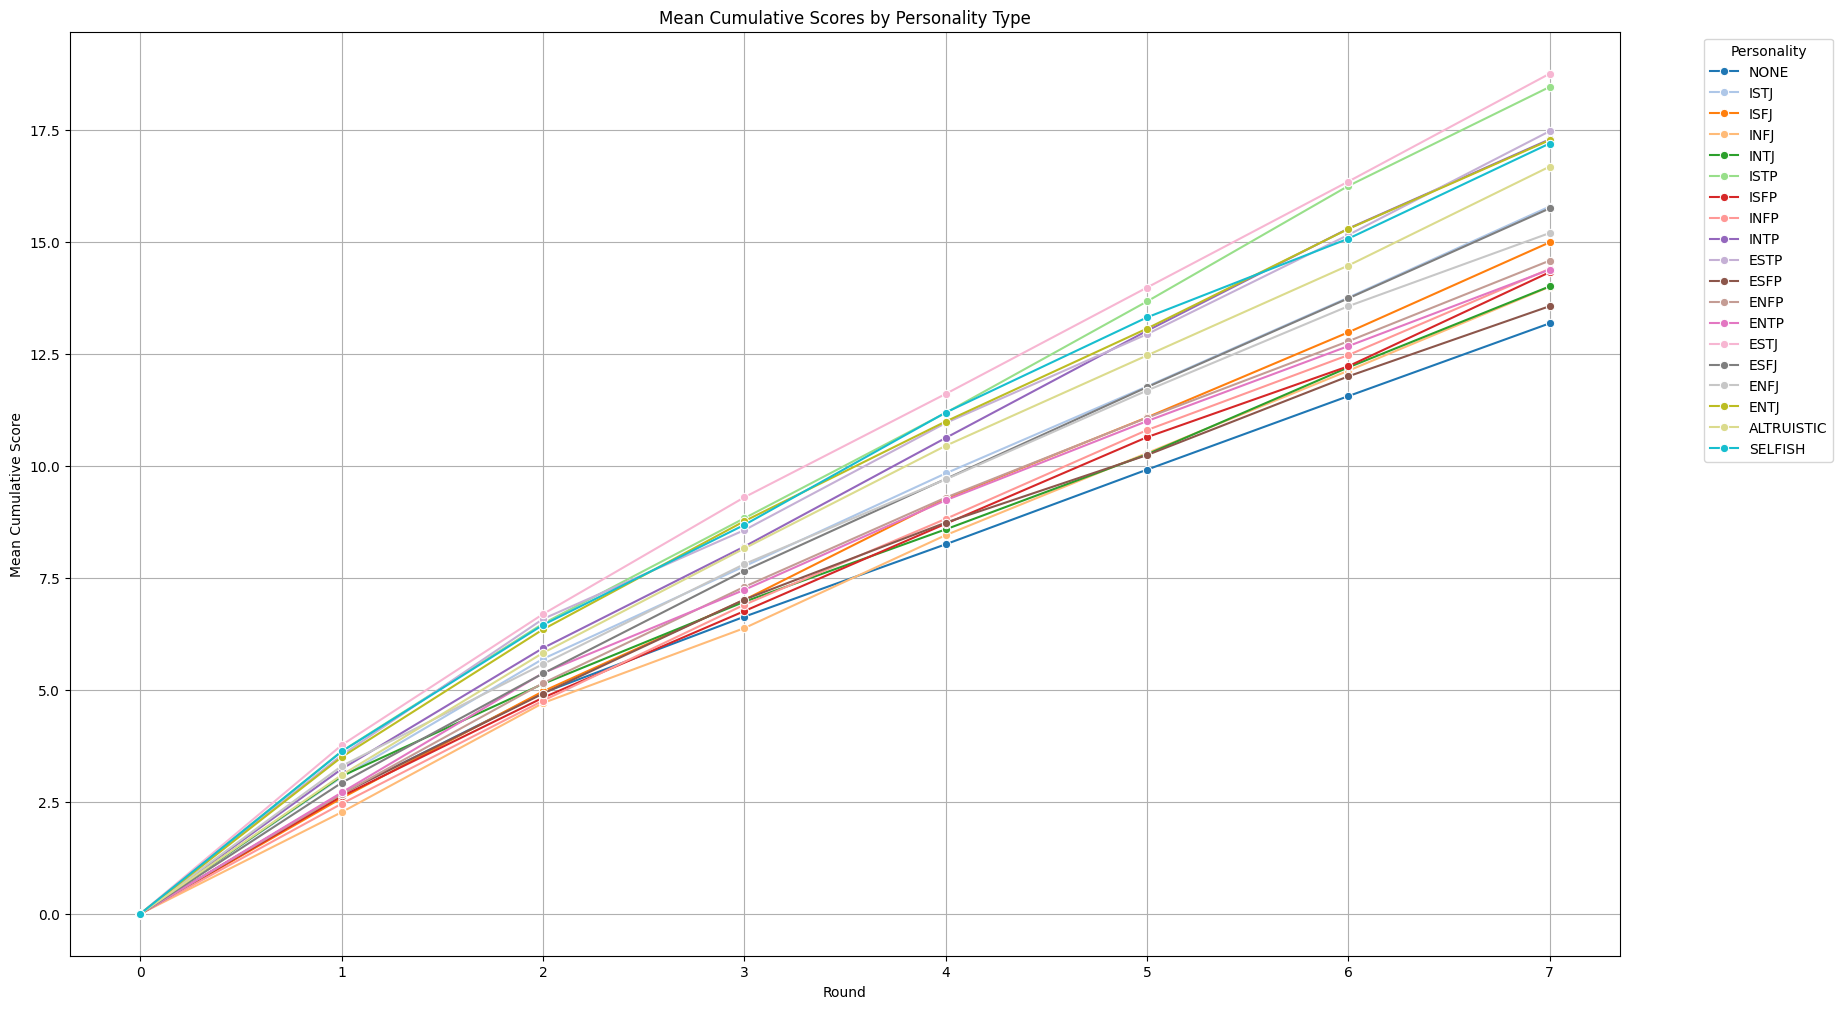

In [8]:

from collections import defaultdict

# Initialize a dictionary to store cumulative scores by personality
cumulative_scores_by_personality = defaultdict(list)

# Iterate through the dataframe and collect cumulative scores
for i, row in df.iterrows():
    for personality, scores in zip([row['personality_1'], row['personality_2']], [row['agent_1_cumulative_scores'], row['agent_2_cumulative_scores']]):
        cumulative_scores_by_personality[personality].append(scores)

# Calculate the mean cumulative scores for each personality
mean_cumulative_scores_by_personality = {}
for personality, scores_list in cumulative_scores_by_personality.items():
    # Transpose the list of scores to calculate the mean for each roundviridis
    transposed_scores = list(zip(*scores_list))
    mean_cumulative_scores = [sum(scores) / len(scores) for scores in transposed_scores]
    mean_cumulative_scores_by_personality[personality] = mean_cumulative_scores

# Print the mean cumulative scores for each personality
for personality, mean_scores in mean_cumulative_scores_by_personality.items():
    print(f"Personality: {personality}, Mean Cumulative Scores: {mean_scores}")
    
    # Create a DataFrame for plotting
    plot_data = []
    for personality, mean_scores in mean_cumulative_scores_by_personality.items():
        for round_num, score in enumerate(mean_scores):
            plot_data.append({'Personality': personality, 'Round': round_num, 'Mean Cumulative Score': score})

plot_df = pd.DataFrame(plot_data)

# Plot the mean cumulative scores for each personality
plt.figure(figsize=(20, 12))
sns.lineplot(data=plot_df, x='Round', y='Mean Cumulative Score', hue='Personality', palette='tab20', marker='o')
plt.title('Mean Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Mean Cumulative Score')
plt.legend(title='Personality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# truthfulness
- the altruitic is not much higher, because sometimes the other agent says it will defect and it defects. while the altruistic then wants to stick to the positive message but still mirrors the others aciton,
- this could be explained by different reasons: the prompt is way shorter, so it s not as strong/easy to follow for the agent
- maybe rename to honest

/tmp/ipykernel_3830161/1735302390.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2')


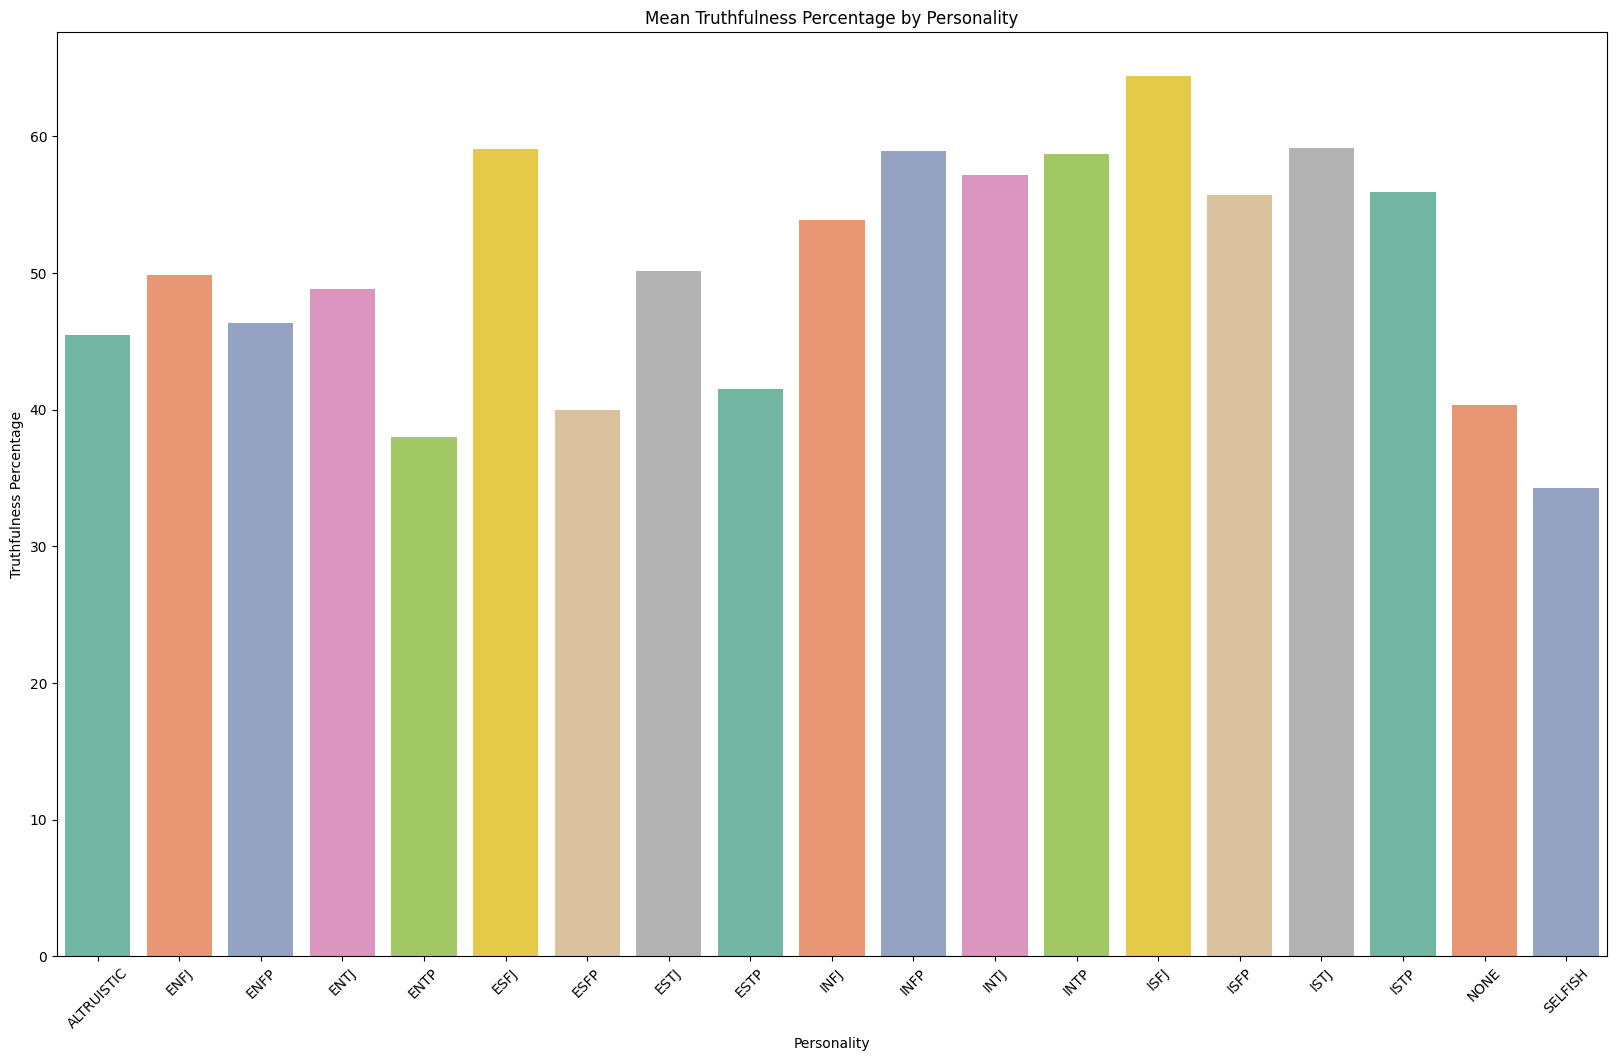

In [9]:
import ast

truthfulness_data = []

for i, row in df.iterrows():
    for personality, truthfulness in zip([row['personality_1'], row['personality_2']], [row['truthful_agent_1'], row['truthful_agent_2']]):
        try:
            truthfulness_list = ast.literal_eval(truthfulness) if isinstance(truthfulness, str) else truthfulness
            truthfulness_bool = [bool(t) for t in truthfulness_list]
            truthfulness_data.append({'Personality': personality, 'Truthful': sum(truthfulness_bool), 'Total': len(truthfulness_bool)})
        except (ValueError, SyntaxError):
            print(f"Skipping row {i} due to malformed data: {truthfulness}")

truthfulness_df = pd.DataFrame(truthfulness_data).groupby("Personality").mean().reset_index()
truthfulness_df['Truthfulness Percentage'] = truthfulness_df['Truthful'] / truthfulness_df['Total'] * 100

# Calculate the mean truthfulness percentage for each personality
#mean_truthfulness = truthfulness_df.groupby('Personality')['Truthfulness Percentage'].mean().reset_index()

# Plot the mean truthfulness percentage for each personality
plt.figure(figsize=(20, 12))
sns.barplot(data=truthfulness_df, x='Personality', y='Truthfulness Percentage', palette='Set2')
plt.title('Mean Truthfulness Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Truthfulness Percentage')
plt.xticks(rotation=45)
plt.savefig(os.path.join(plots_dir, 'mean_truthfulness_percentage_by_personality.png'), bbox_inches='tight')
plt.show()

/tmp/ipykernel_3830161/3374653272.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_3830161/3374653272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_3830161/3374653272.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2'

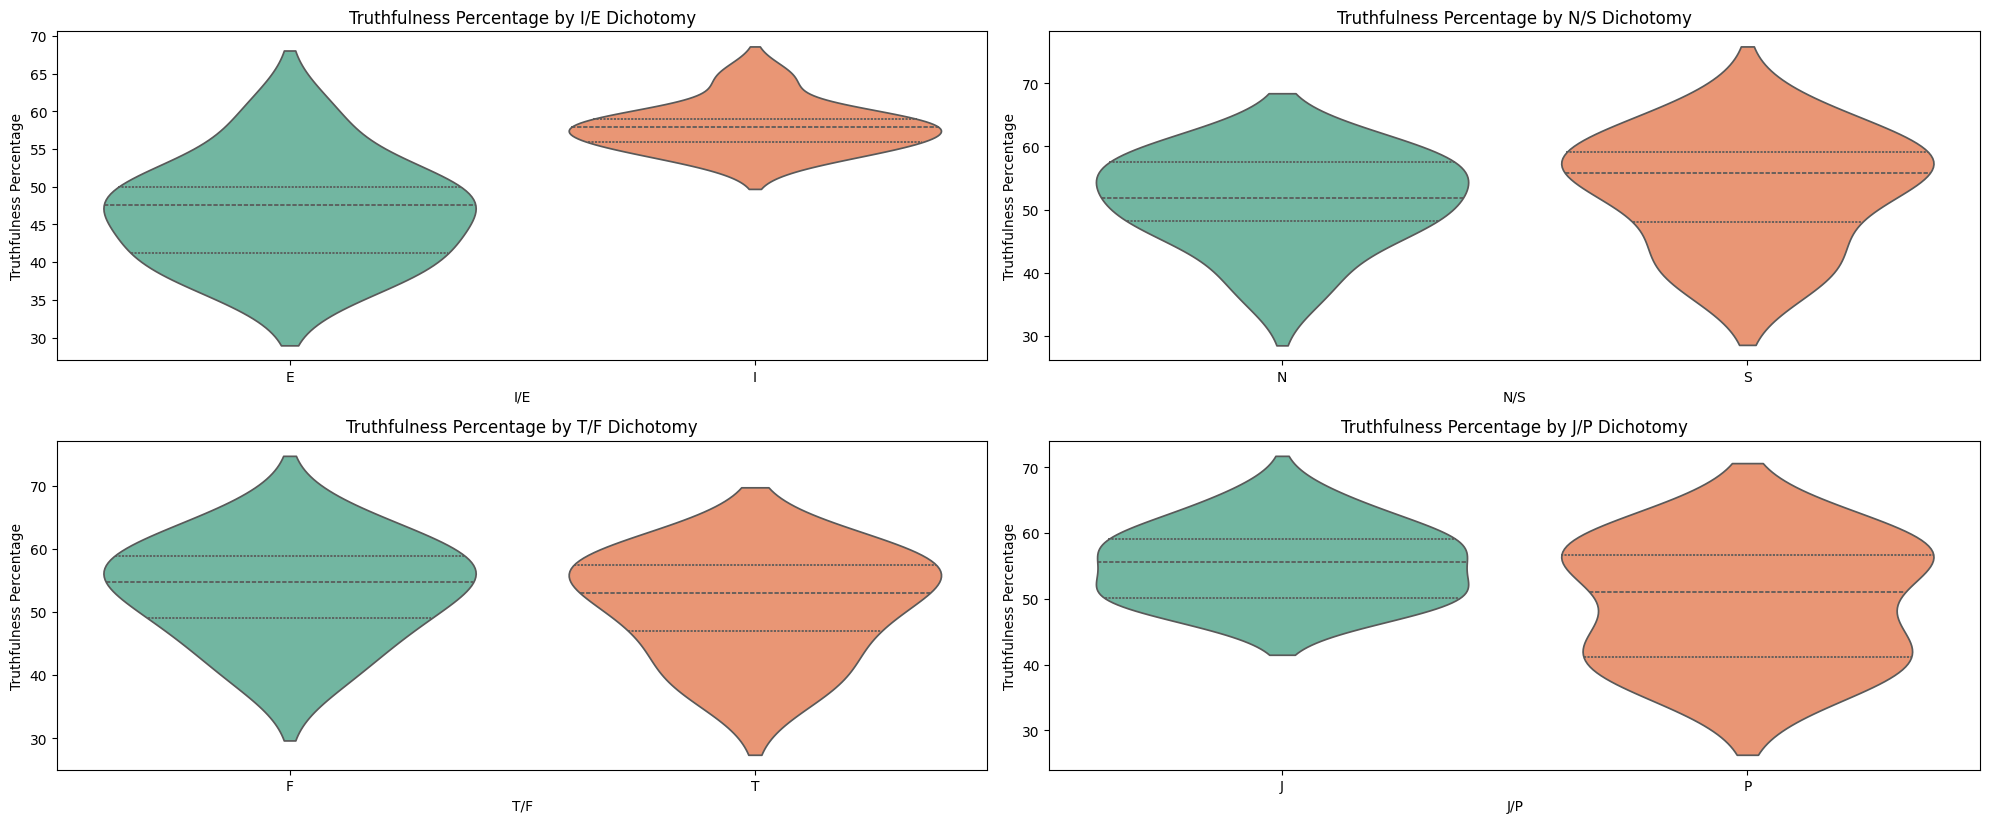

In [10]:
#mean_truthfullness = truthfulness_df.groupby('Personality')['Truthfulness Percentage'].mean().reset_index()
mean_truthfullness = truthfulness_df.copy()
# Filter out the control groups
filtered_df = mean_truthfullness[~mean_truthfullness['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()


# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Truthfulness Percentage'] = mean_truthfullness['Truthfulness Percentage']

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by J/P Dichotomy')

"""
plt.subplot(3, 2, 5)
sns.violinplot(data=mean_truthfulness[mean_truthfulness['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])], x='Personality', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by NONE, Altruistic, and Selfish')
"""

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'truthfulness_percentage_by_dichotomy.png'), bbox_inches='tight')
plt.show()

/tmp/ipykernel_3830161/2656978921.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_TF[df_TF['game_name'] == game], x='T/F', y='strategy_switches', palette='muted', ax=ax)
/tmp/ipykernel_3830161/2656978921.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_TF[df_TF['game_name'] == game], x='T/F', y='strategy_switches', palette='muted', ax=ax)
/tmp/ipykernel_3830161/2656978921.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_TF[df_TF['game_name'] == game], x='T/F', y='strategy_switches', palette='mute

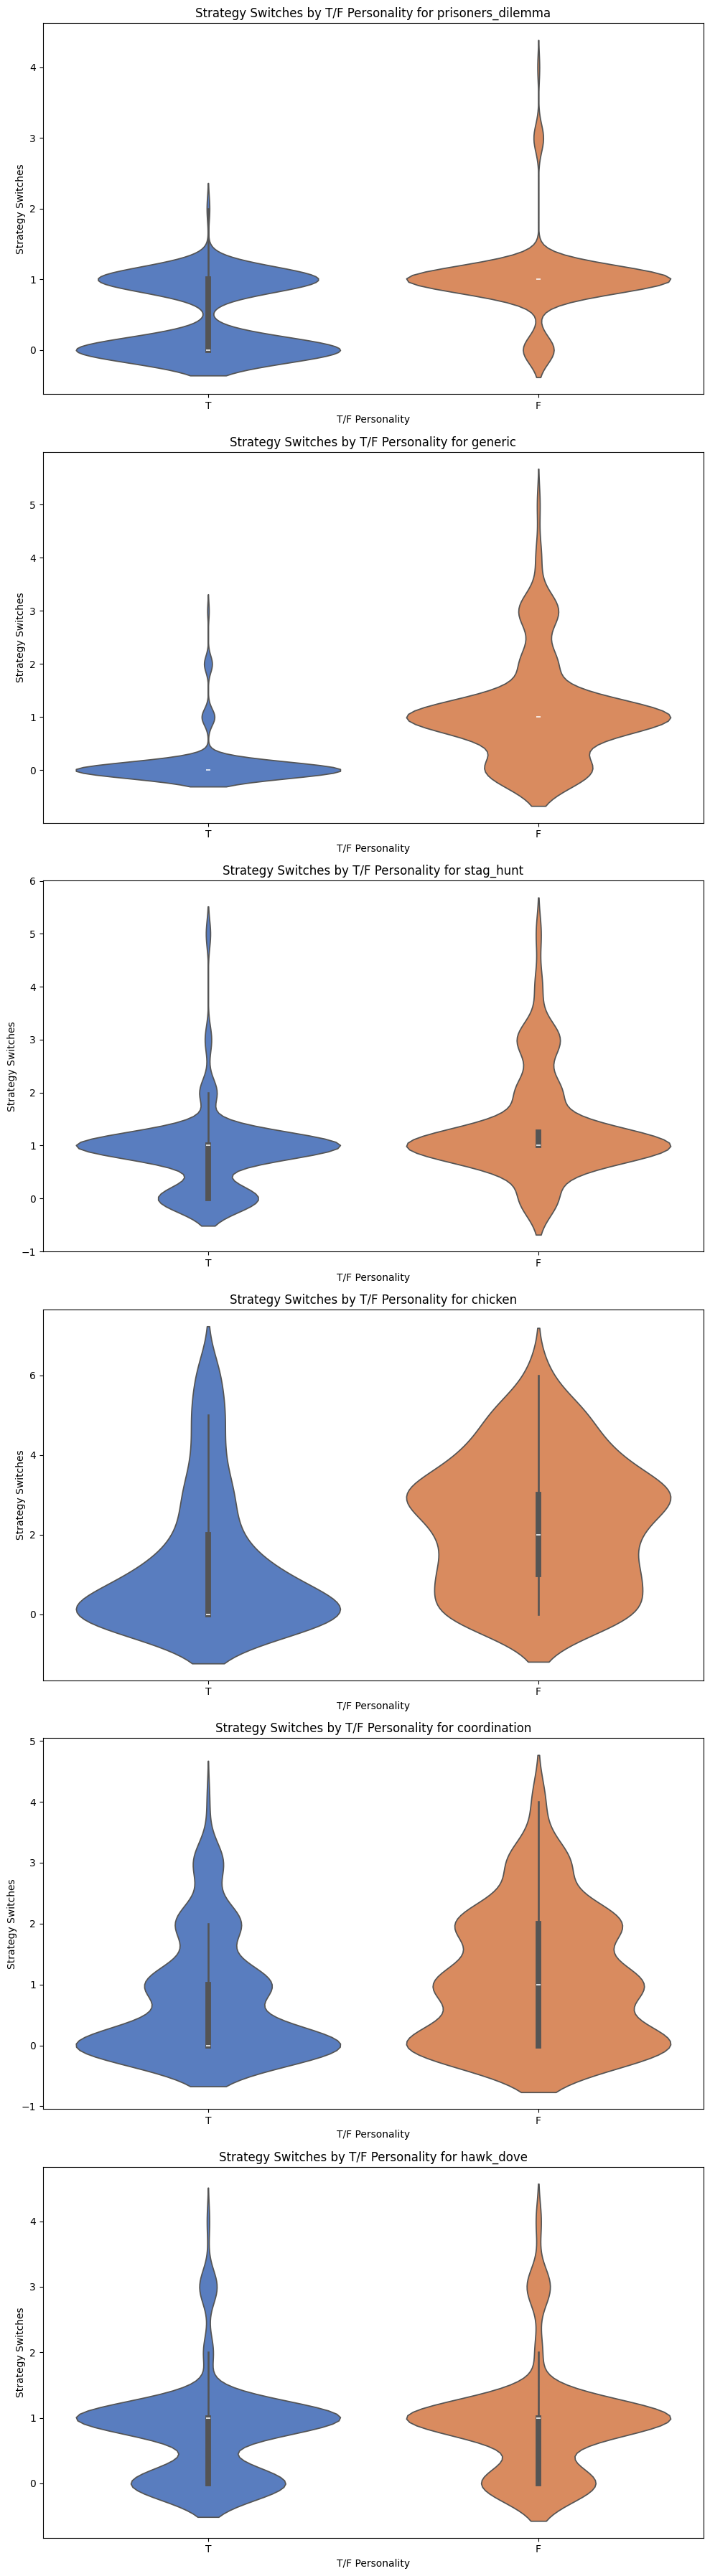

In [11]:
#get the  personality T/F strategy_switches_agent_1 and 2
df_TF = pd.DataFrame(columns = ["game_name","T/F", "strategy_switches"])
df_TF = df[['game_name', 'T/F_1', 'strategy_switches_agent_1']].rename(columns={'T/F_1': 'T/F', 'strategy_switches_agent_1': 'strategy_switches'})
df_TF_2 = df[['game_name', 'T/F_2', 'strategy_switches_agent_2']].rename(columns={'T/F_2': 'T/F', 'strategy_switches_agent_2': 'strategy_switches'})
df_TF = pd.concat([df_TF, df_TF_2], ignore_index=True)
df_TF = df_TF[df_TF['T/F'].notna()]

#plot the strategy switches by personality T/F strategy_switches_agent_1 and 2

# Create a separate plot for each game
unique_games = df_TF['game_name'].unique()

# Create subplots for each game
num_games = len(unique_games)
fig, axes = plt.subplots(num_games, 1, figsize=(10, 6 * num_games))

for ax, game in zip(axes, unique_games):
    sns.violinplot(data=df_TF[df_TF['game_name'] == game], x='T/F', y='strategy_switches', palette='muted', ax=ax)
    ax.set_title(f'Strategy Switches by T/F Personality for {game}')
    ax.set_xlabel('T/F Personality')
    ax.set_ylabel('Strategy Switches')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'strategy_switches_by_game.png'))
plt.show()

# who lied first
- often, the agent stop being truthful because they keep getting lied to
- which is why i caught some pointers to show if the agent lied first in each conversation.
- we ignore the cases when the other agent defects first, even if they are being truthful about the fact theat they will defect.
- to explain why it looks like altruistic would lie ,first, but it s just a consequence of the other saying they will defect explictly.

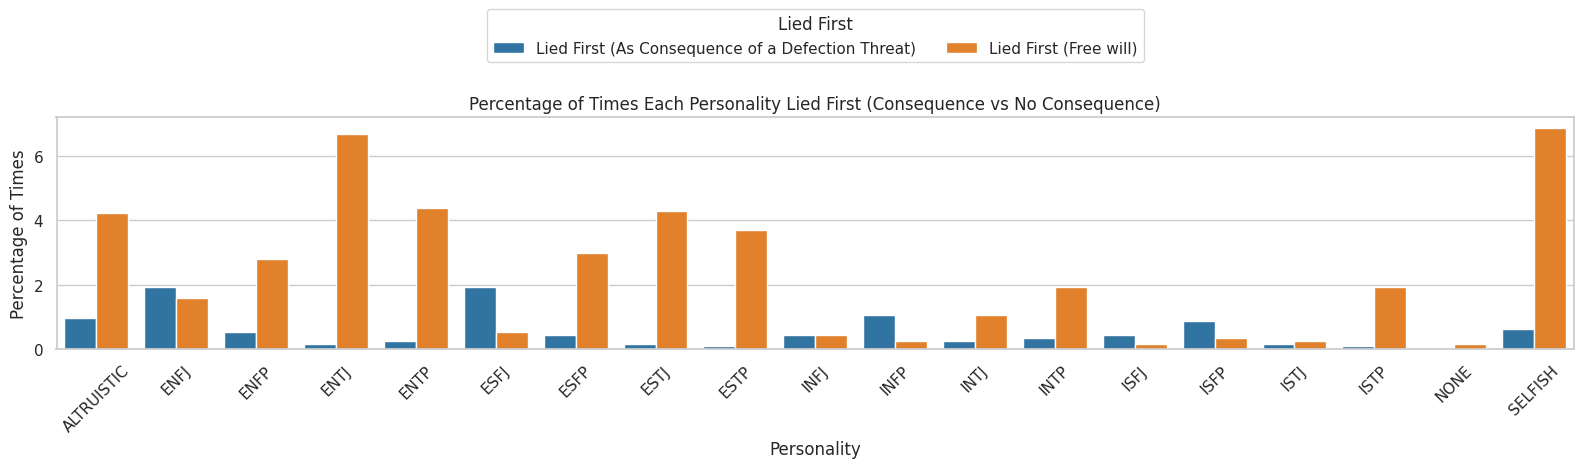

/tmp/ipykernel_3830161/1887846024.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_times_mbti['I/E'] = plot_data_times_mbti['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None)
/tmp/ipykernel_3830161/1887846024.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_times_mbti['N/S'] = plot_data_times_mbti['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S' if x not in nonmbti else None)
/tmp/ipykernel_3830161/1887846024.py:87: SettingWithCopy

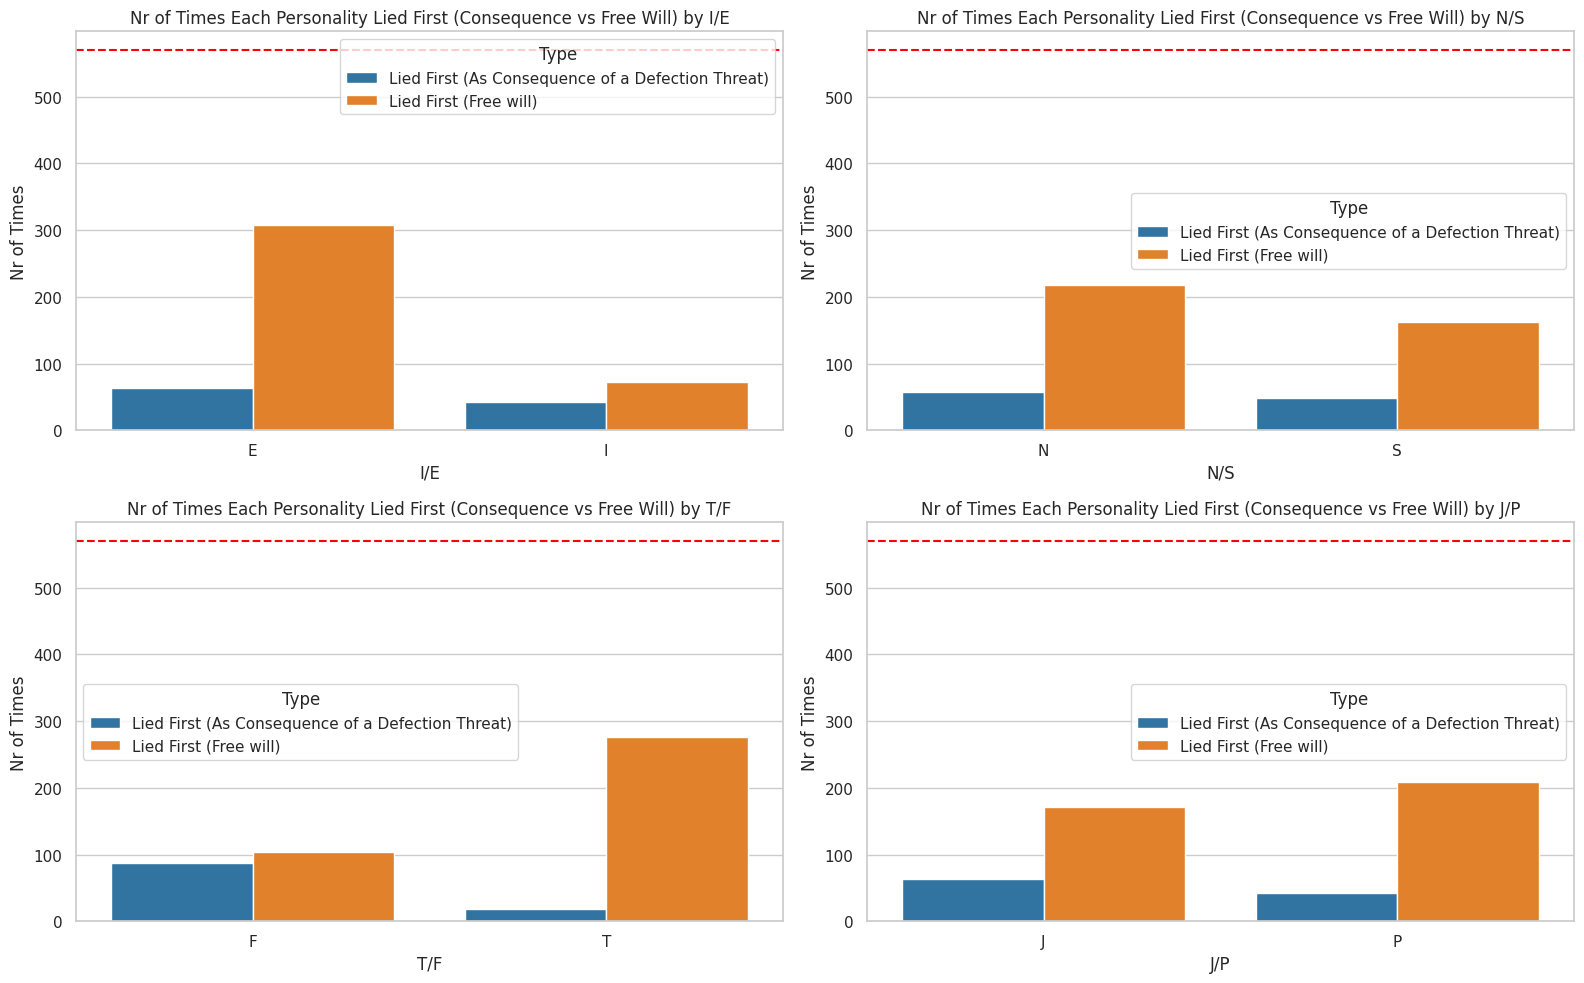

In [19]:
import seaborn as sns

df['lied_first_1'] = [False] * len(df)
df['lied_first_2'] = [False] * len(df)
df['defected_first_1'] = [False] * len(df)
df['defected_first_2'] = [False] * len(df)

for i, row in df.iterrows():
    personality_1 = row['personality_1']
    personality_2 = row['personality_2']
    
    for truthful_1, truthful_2, intent_1, intent_2 in zip(row['truthful_agent_1'], row['truthful_agent_2'], row['intent_agent_1'], row['intent_agent_2']):
        if (truthful_1 == False) and (truthful_2 == True):
            df.at[i, 'lied_first_1'] = True
            break
        elif (truthful_1 == True) and (truthful_2 == False):
            df.at[i, 'lied_first_2'] = True
            break
    for action_1, action_2 in zip(row['agent_1_actions'], row['agent_2_actions']):
        if (action_1 == 'defect') and (action_2 == 'cooperate'):
            
            df.at[i, 'defected_first_1'] = True
            break
        elif (action_1 == 'cooperate') and (action_2 == 'defect'):
            df.at[i, 'defected_first_2'] = True
            break
        elif (action_1 == 'defect') and (action_2 == 'defect'):
            if (intent_1 == 'defect') and (intent_2 == 'cooperate'):
                df.at[i, 'defected_first_2'] = True
                break
            elif (intent_1 == 'cooperate') and (intent_2 == 'defect'):
                df.at[i, 'defected_first_1'] = True
                break
#calculate nrs of times
# Calculate the nr of times each personality lied first
first_liars = df.groupby('personality_1')['lied_first_1'].sum().to_dict()
first_liars.update(df.groupby('personality_2')['lied_first_2'].sum().to_dict())

# Calculate the number of times each personality lied first and whether it was a consequence of being defected first
first_liars_consequence = df.groupby('personality_1')['defected_first_2'].sum().to_dict()
first_liars_consequence.update(df.groupby('personality_2')['defected_first_1'].sum().to_dict())

# Calculate the number of times each personality lied first without being defected first
first_liars_no_consequence = {k: abs(first_liars[k] - first_liars_consequence.get(k, 0)) for k in first_liars.keys()}

#calculate % of times each personality lied first
first_liars_percentage = {k: (v / df.shape[0]) * 100 for k, v in first_liars.items()}
first_liars_consequence_percentage = {k: (v / df.shape[0]) * 100 for k, v in first_liars_consequence.items()}
first_liars_no_consequence_percentage = {k: (v / df.shape[0]) * 100 for k, v in first_liars_no_consequence.items()}


# Create a DataFrame for plotting
plot_data_times = pd.DataFrame({
    'Personality': list(first_liars.keys()),
    'Lied First (As Consequence of a Defection Threat)': list(first_liars_consequence.values()),
    'Lied First (Free will)': list(first_liars_no_consequence.values())
})

plot_data_percentage = pd.DataFrame({
    'Personality': list(first_liars_percentage.keys()),
    'Lied First (As Consequence of a Defection Threat)': list(first_liars_consequence_percentage.values()),
    'Lied First (Free will)': list(first_liars_no_consequence_percentage.values())
})

plt.figure(figsize=(16, 6))
sns.barplot(data=plot_data_percentage.melt(id_vars="Personality", var_name="Type", value_name="Percentage"),
            x="Personality", y="Percentage", hue="Type", palette=['#1f77b4', '#ff7f0e'])
plt.title('Percentage of Times Each Personality Lied First (Consequence vs No Consequence)')
plt.xlabel('Personality')
plt.ylabel('Percentage of Times')
plt.legend(title='Lied First', loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'lied_first_percentage.png'))
plt.show()

#max amount of first lies by dichotomy
max_lies = len(df)/2

# Remove the non-MBTI for labeling
plot_data_times_non_mbti = plot_data_times[plot_data_times['Personality'].isin(nonmbti)]
plot_data_times_mbti = plot_data_times[~plot_data_times['Personality'].isin(nonmbti)]
plot_data_times_non_mbti = plot_data_times_non_mbti[plot_data_times_non_mbti['Personality'] == 'NONE']

plot_data_times_mbti['I/E'] = plot_data_times_mbti['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E' if x not in nonmbti else None)
plot_data_times_mbti['N/S'] = plot_data_times_mbti['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S' if x not in nonmbti else None)
plot_data_times_mbti['T/F'] = plot_data_times_mbti['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F' if x not in nonmbti else None)
plot_data_times_mbti['J/P'] = plot_data_times_mbti['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P' if x not in nonmbti else None)

plot_data_times = pd.concat([plot_data_times_mbti, plot_data_times_non_mbti], ignore_index=True)

plot_data_times_IE = plot_data_times[["I/E", "Lied First (As Consequence of a Defection Threat)", "Lied First (Free will)"]].groupby("I/E").sum().reset_index()
plot_data_times_NS = plot_data_times[["N/S", "Lied First (As Consequence of a Defection Threat)", "Lied First (Free will)"]].groupby("N/S").sum().reset_index()
plot_data_times_TF = plot_data_times[["T/F", "Lied First (As Consequence of a Defection Threat)", "Lied First (Free will)"]].groupby("T/F").sum().reset_index()
plot_data_times_JP = plot_data_times[["J/P", "Lied First (As Consequence of a Defection Threat)", "Lied First (Free will)"]].groupby("J/P").sum().reset_index()
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot the bars with two colors using seaborn
plt.figure(figsize=(16, 10))

# I/E Plot
plt.subplot(2, 2, 1)
sns.barplot(data=plot_data_times_IE.melt(id_vars="I/E", var_name="Type", value_name="Count"), 
            x="I/E", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e'])
plt.axhline(y=max_lies, color='red', linestyle='--', label='Max Lies')
plt.title('Nr of Times Each Personality Lied First (Consequence vs Free Will) by I/E')
plt.xlabel('I/E')
plt.ylabel('Nr of Times')

# N/S Plot
plt.subplot(2, 2, 2)
sns.barplot(data=plot_data_times_NS.melt(id_vars="N/S", var_name="Type", value_name="Count"), 
            x="N/S", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e'])
plt.axhline(y=max_lies, color='red', linestyle='--')
plt.title('Nr of Times Each Personality Lied First (Consequence vs Free Will) by N/S')
plt.xlabel('N/S')
plt.ylabel('Nr of Times')

# T/F Plot
plt.subplot(2, 2, 3)
sns.barplot(data=plot_data_times_TF.melt(id_vars="T/F", var_name="Type", value_name="Count"), 
            x="T/F", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e'])
plt.axhline(y=max_lies, color='red', linestyle='--')
plt.title('Nr of Times Each Personality Lied First (Consequence vs Free Will) by T/F')
plt.xlabel('T/F')
plt.ylabel('Nr of Times')

# J/P Plot
plt.subplot(2, 2, 4)
sns.barplot(data=plot_data_times_JP.melt(id_vars="J/P", var_name="Type", value_name="Count"), 
            x="J/P", y="Count", hue="Type", palette=['#1f77b4', '#ff7f0e'])
plt.axhline(y=max_lies, color='red', linestyle='--')
plt.title('Nr of Times Each Personality Lied First (Consequence vs Free Will) by J/P')
plt.xlabel('J/P')
plt.ylabel('Nr of Times')

# Adjust the legend to appear outside the plots
#plt.legend(title='Lied First', bbox_to_anchor=(1.05, 1), loc='upper center')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'lied_first_by_dichotomy.png'), bbox_inches='tight')
plt.show()

 

## truthfulness
- truthfullness is defined by how many times the agent said the truth/total actions
- maybe also compare when we take into account if the lies were by free will and not as a consequence of defection

In [13]:
def calculate_how_truthfull(list_bools):
    return sum(list_bools) / len(list_bools)

# Extract the last value of cumulative scores and truthfulness for each agent
df['agent_1_final_score'] = df['agent_1_cumulative_scores'].apply(lambda x: x[-1])
df['agent_2_final_score'] = df['agent_2_cumulative_scores'].apply(lambda x: x[-1])
df['agent_1_final_truthfulness'] = df['truthful_agent_1'].apply(lambda x: calculate_how_truthfull(x))
df['agent_2_final_truthfulness'] = df['truthful_agent_2'].apply(lambda x: calculate_how_truthfull(x))

# Create a new DataFrame to store the correlation data
correlation_data = []

# Iterate through the dataframe and collect the necessary data
for i, row in df.iterrows():
    correlation_data.append({
        'Personality': row['personality_1'],
        'Final Score': row['agent_1_final_score'],
        'Truthfulness': row['agent_1_final_truthfulness']
    })
    correlation_data.append({
        'Personality': row['personality_2'],
        'Final Score': row['agent_2_final_score'],
        'Truthfulness': row['agent_2_final_truthfulness']
    })

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data)
correlation_df_groups = correlation_df.groupby('Personality').sum().reset_index()

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(correlation_df_groups[['Truthfulness']], correlation_df_groups[['Final Score']])

correlation_df_groups['Predicted Final Score'] = reg.predict(correlation_df_groups[['Truthfulness']])
correlation_df_groups

,Personality,Final Score,Truthfulness,Predicted Final Score
0,ALTRUISTIC,2002,54.571429,1874.889568
1,ENFJ,1824,59.857143,1876.034156
2,ENFP,1750,55.571429,1875.106112
3,ENTJ,2073,58.571429,1875.755742
4,ENTP,1726,45.571429,1872.940676
5,ESFJ,1890,70.857143,1878.416135
6,ESFP,1628,48.000000,1873.466567
7,ESTJ,2251,60.142857,1876.096025
8,ESTP,2097,49.857143,1873.868720
9,INFJ,1666,64.142857,1876.962199
